# Linear Least Square Fitting

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib notebook 

# Declaring variables

Simulation data from synchroton.

In [2]:
# synch_data = pd.read_csv('Synch_spectrum.txt',sep = "\s+", names = ['Frequency (Hz)','Intensity (erg cm-2 s-1 sr-1 Hz-1)'],skiprows = [0,1])
# xpoints = synch_data['Frequency (Hz)']
# ypoints = synch_data['Intensity (erg cm-2 s-1 sr-1 Hz-1)']

Averages of the intensities for the 9 different areas in the sky.

In [4]:
avg_data = pd.read_csv('avg_intensities.txt',sep = "\s+", names = ['Frequency (GHz)','Intensity'],skiprows = [0,1])
xpoints = avg_data['Frequency (GHz)'].iloc[:30] #assigning x values to frequency column

In [5]:
arr = xpoints[np.arange(xpoints.size)].values.reshape((xpoints.size,1)) #array of x values reshaped
begin_x = np.linspace(0.01,0.05, 10,endpoint=False).reshape(10,1) #additional x points to extend curve
arr = np.vstack([begin_x,arr]) #combining begin_x array and arr array
one_arr = np.ones([arr.size,1]) #array of ones concatenated to matrices

# Determining x matrices and y vector

Here, I am taking the x and y points and adding them to their respective matrices. Note that the 'xmatrix' is equivalent to the A matrix in Adrian's notes. For a linear or quadratic x matrix:

$$X_{linear} = \begin{bmatrix}
1 & x_{1} \\
1 & x_{2} \\
\vdots & \vdots \\
\end{bmatrix}, \quad
X_{quadratic} = \begin{bmatrix}
1 & x_{1} & x_{1}^{2}\\
1 & x_{2} & x_{2}^{2} \\
\vdots & \vdots & \vdots\\
\end{bmatrix}
$$

For a cubic function just add another column for $x^3$. While the y vector is just the y points:
$\bar{y} = \begin{bmatrix}
y_{1} \\
y_{2} \\
\vdots \\
\end{bmatrix}
$

In [6]:
xmatrix = np.hstack([one_arr, arr]) #appending array of ones to array of xvalues
xmatrix_quad = np.hstack([xmatrix,arr**2]) #appending xmatrix to array of xvalues squared 
xmatrix_cub = np.hstack([xmatrix_quad,arr**3]) #appending xmatrix_quad to array of xvalues cubed

# Power Law

This is an attempt to fit a power law in the form of $y = \beta x^\alpha$. To fit the power law, it must be linearized since, according to Adrian's notes, the "linear part of the term 'linear fit' just means linear in the parameters". One way to do that (based on online searching) is by applying log to both sides to make:

$log(y) = log (\beta x^\alpha) = log(\beta) + log(x^\alpha) = log(\beta) + \alpha log(x)$

Therefore, the linearization of $y = \beta x^\alpha$ is $log(y) = log(\beta) + \alpha log(x)$. Let $y^{'}=log(y)$ and $x^{'}=log(x)$ so that $y^{'} = log(\beta) + \alpha x^{'}$.

With this, we can pretty much proceed as with the linear case but here the x matrix and y vector will be:

$$X_{power} = \begin{bmatrix}
1 & log(x_{1}) \\
1 & log(x_{2}) \\
\vdots & \vdots \\
\end{bmatrix}, \quad
\bar{y} = \begin{bmatrix}
log(y_{1}) \\
log(y_{2}) \\
\vdots \\
\end{bmatrix}
$$

In [7]:
xmatrix_pow = np.hstack([one_arr,np.log(arr)]) #appending array of ones to array of log xvalues

# Noise covariance matrix and y model

This method is based on Adrian's notes to determing the $\hat{x}$ for $y^{model} = A\hat{x}$. From his notes, $\hat{x}$ is defined as $\hat{x} = [A^TN^{-1}A]^{-1}A^TN^{-1}\bar{y}$.

From the earlier code, I already found $A$ = xmatrix and $\bar{y}$. To find $N$, I first need to find the variance or $\sigma^{2}$. The $N$ matrix is as follows:
$$ N = \begin{pmatrix}
\sigma_{1}^{2} & 0 & 0 &\ldots{} \\
0 & \sigma_{2}^{2} & 0 & \ldots{} \\
0 & 0 & \sigma_{3}^{2} & \ldots{} \\
\vdots & \vdots & \ddots \\
\end{pmatrix} $$

To find $\sigma^{2}$, I used the following formula where $N$ is the number of terms and $\mu$ is the mean:
$$\sigma^{2} = \frac{1}{N} \sum_{i}^{N}{(x_{i} - \mu)^{2}}$$

Since I have determined the values for $A, N, \bar{y}$, to find $\hat{x}$, it's just a matter of multiplying everything for $\hat{x} = [A^TN^{-1}A]^{-1}A^TN^{-1}\bar{y}$. I broke down the steps of the process:
<ol>
<li>$A^TN^{-1}$</li>
<li>$A^TN^{-1}\bar{y}$</li>
<li>$[A^TN^{-1}A]^{-1}$</li>
<li>$\hat{x} = [A^TN^{-1}A]^{-1}A^TN^{-1}\bar{y}$</li>
<li>$y^{model} = A\hat{x}$</li>
</ol>	


In the below function, since I am adding additional x points to extend the curve, I am calculating the x-bar (parameters for fit) based on the x-values from the data. Then, after calculating x bar, I am multiplying the x_matrix which has both the x-values from the data and the additional x points to extend the curve with x_bar to get the y values for the fit.

In [12]:
#     #variance = np.hstack(yerr**2) #stack array horizontally  
#     avg_x = np.mean(xval) #average of x points
#     variance = avg_x
#     noise_cov = variance * np.identity(xpoints.size)

In [11]:
#parameters x_matrix, x points, y points, and index of x matrix where begin_x values end 
#returns y_model, x_bar (parameters for fit) and error covariance
def y_model(x_matrix,xval,yval,index_begin_x = 10):

    xval_matrix = x_matrix[index_begin_x:] #slicing array to section with only x values from data
    
    avg_x = np.mean(xval) #average of x points
    variance =(((yval - avg_x)**2)/(xval.size)).values.reshape((yval.size,1)) #calculating variance
    variance = np.hstack(variance)
    noise_cov = np.diag(variance) #diagonal of variance
    
    #calculating x_bar with sliced x_matrix
    dot_matrix = np.dot(xval_matrix.T,np.linalg.inv(noise_cov)) #Step 1
    doty_matrix = np.dot(dot_matrix,yval) #Step 2
    inv_matrix = np.linalg.inv(np.dot(dot_matrix,xval_matrix)) #Step 3
    x_bar = np.dot(inv_matrix, doty_matrix) #Step 4
 
    #calculating y_model with x_matrix which has both x values from data and additional x points
    y_model = np.dot(x_matrix, x_bar) #Step 5
    return y_model, x_bar, inv_matrix

# Calling Functions and Graphing

In [13]:
#rd = np.random.default_rng()
#yerr= rd.random((ypoints.size))*10**10
#plt.errorbar(xpoints,ypoints,yerr,fmt='r.') 
#plt.scatter(avg_data['Frequency (GHz)'],avg_data['Intensity'], color='m')

<IPython.core.display.Javascript object>


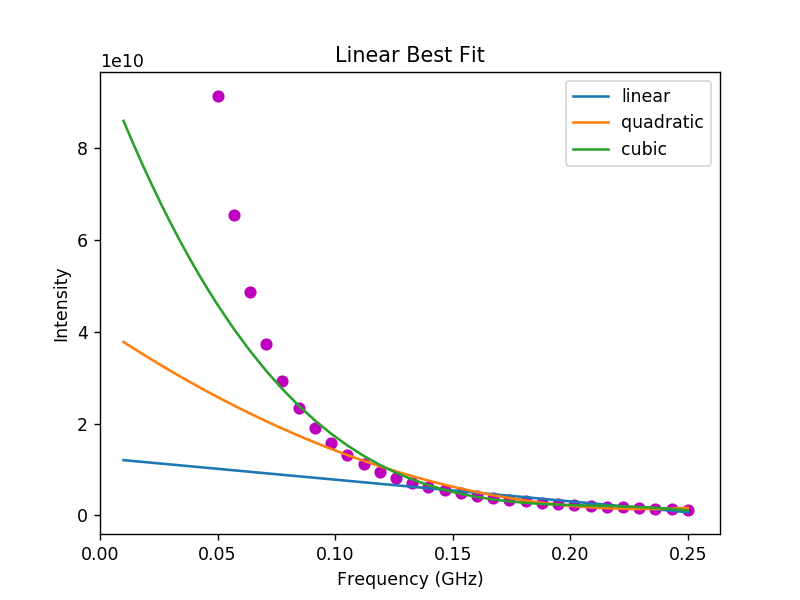

<IPython.core.display.Javascript object>


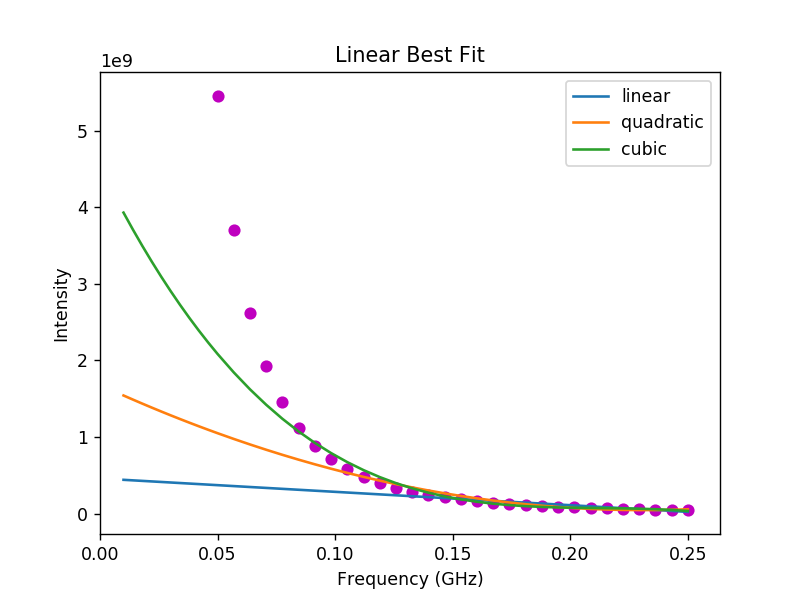

<IPython.core.display.Javascript object>


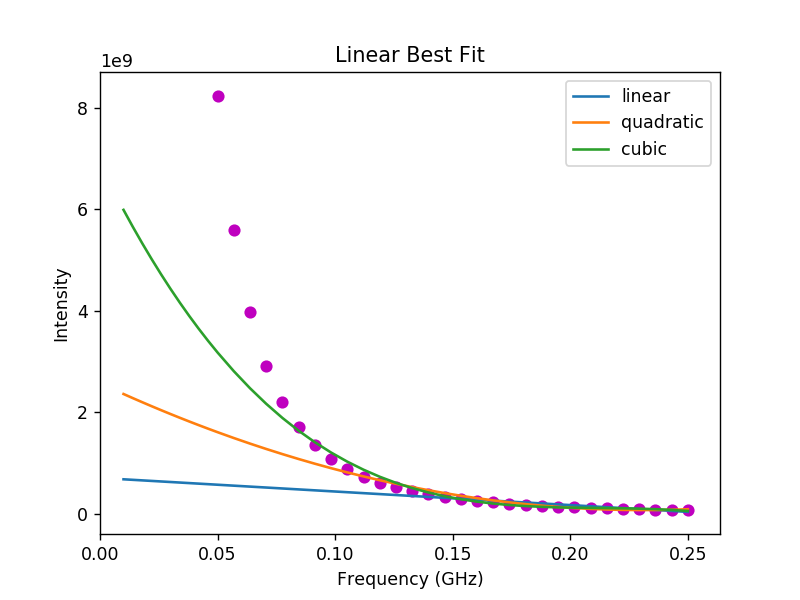

<IPython.core.display.Javascript object>


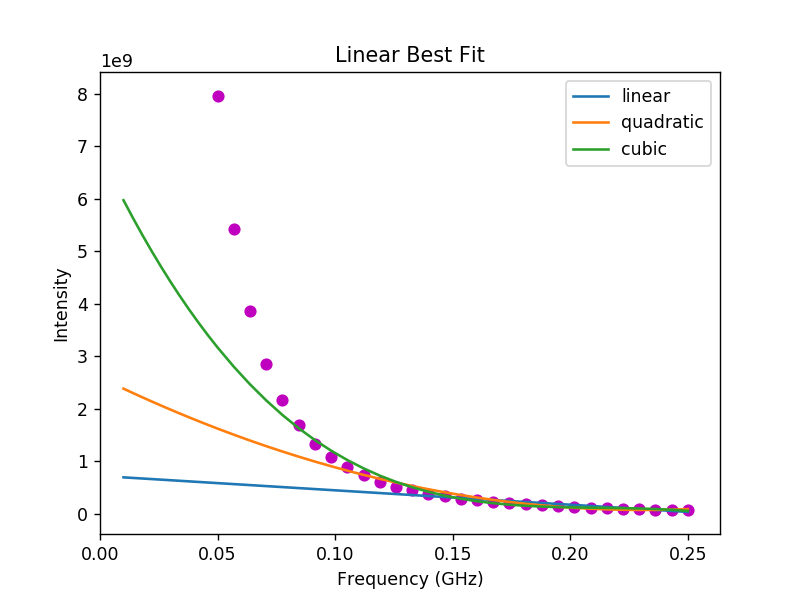

<IPython.core.display.Javascript object>


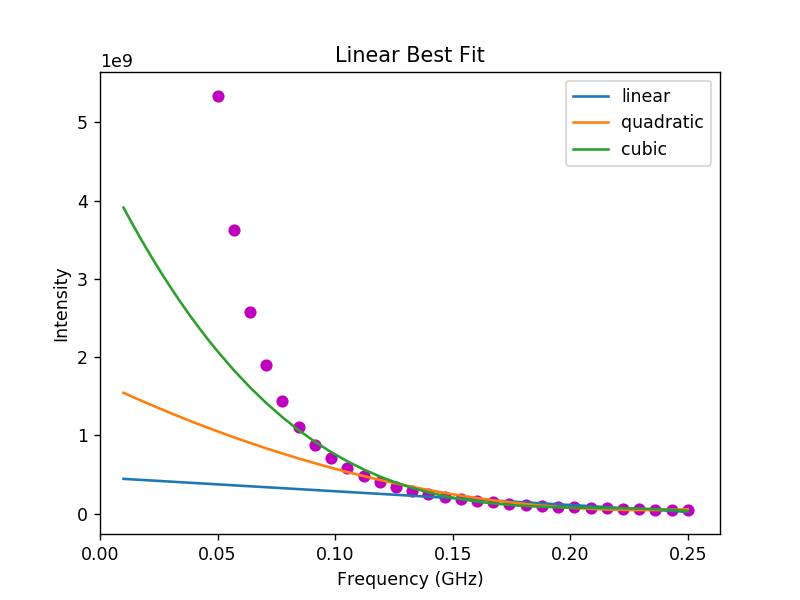

<IPython.core.display.Javascript object>


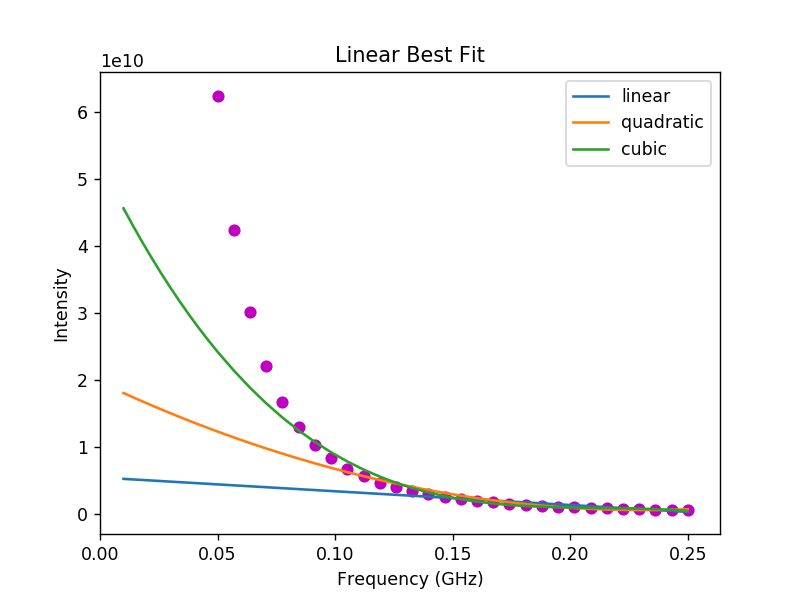

<IPython.core.display.Javascript object>


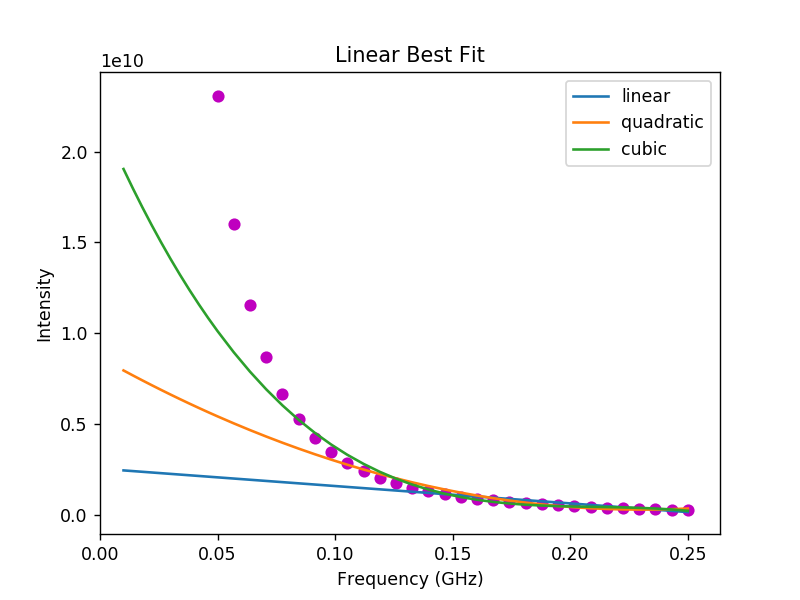

<IPython.core.display.Javascript object>


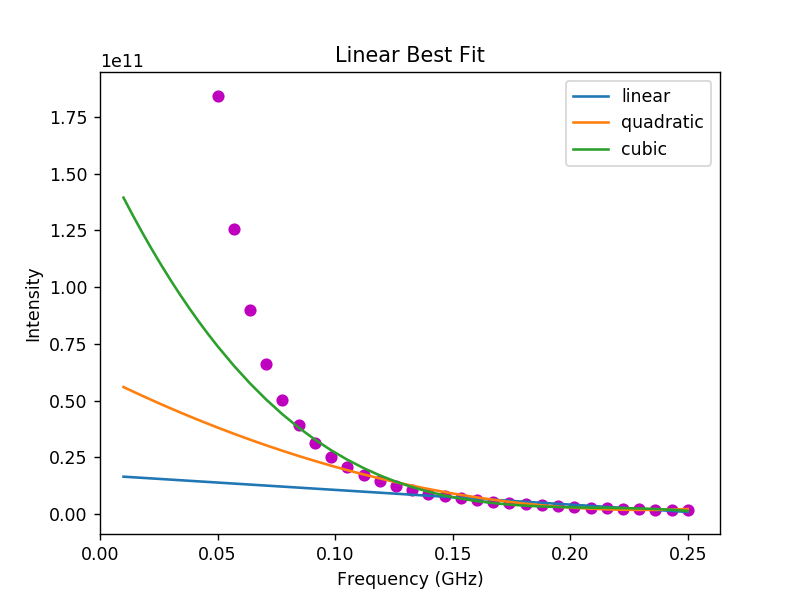

<IPython.core.display.Javascript object>


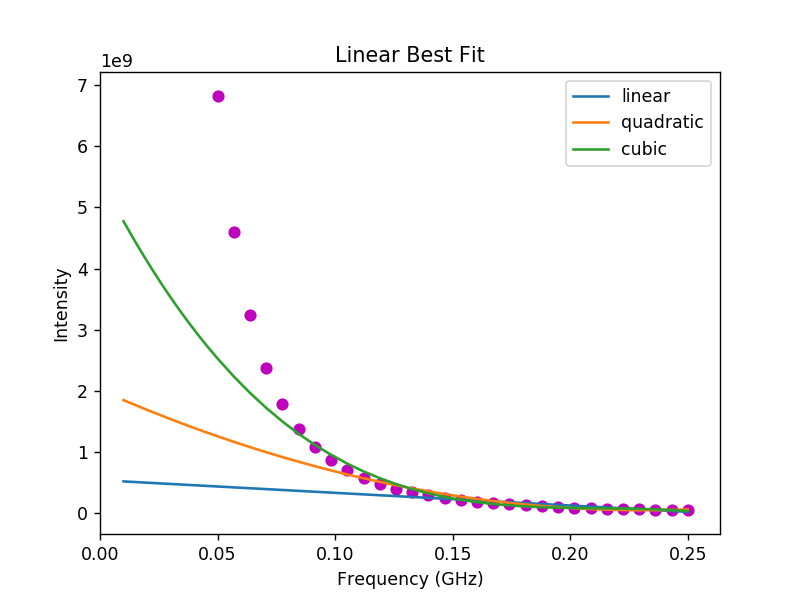

In [15]:
for y in np.arange(9): #looping through 9 graphs corresponding to 9 different areas of sky
    #assigning ypoints to section of Intensity column that corresponds to graph
    ypoints = avg_data['Intensity'].iloc[y*30:30*(y+1)] 
    plt.figure()
    lin_fit, lin_param, lin_error = y_model(xmatrix, arr, ypoints)
    quad_fit, quad_param, quad_error = y_model(xmatrix_quad, arr,ypoints)
    cub_fit, cub_param, cub_error = y_model(xmatrix_cub,arr, ypoints)
    
    plt.plot(arr, lin_fit, label='linear')
    plt.plot(arr, quad_fit, label='quadratic')
    plt.plot(arr, cub_fit, label='cubic')
    plt.scatter(xpoints,ypoints, color='m')
    plt.legend(loc='upper right')
    plt.title("Linear Best Fit")
    plt.xlabel(xpoints.name)
    plt.ylabel(ypoints.name)
    plt.xlim(left=0)
    plt.show()

<IPython.core.display.Javascript object>


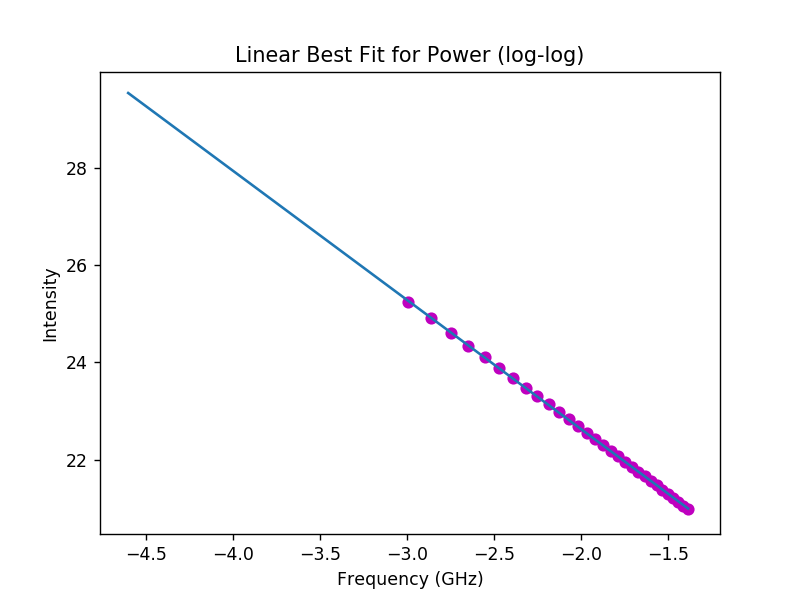

<IPython.core.display.Javascript object>


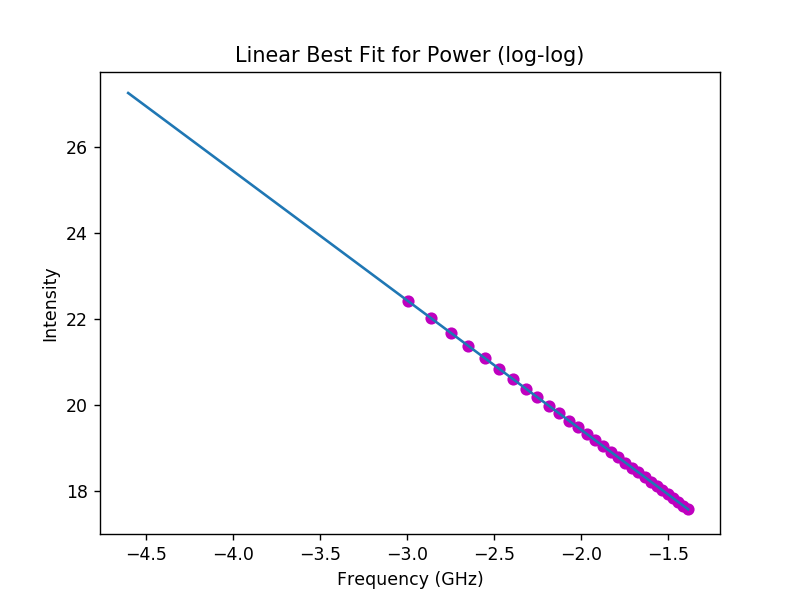

<IPython.core.display.Javascript object>


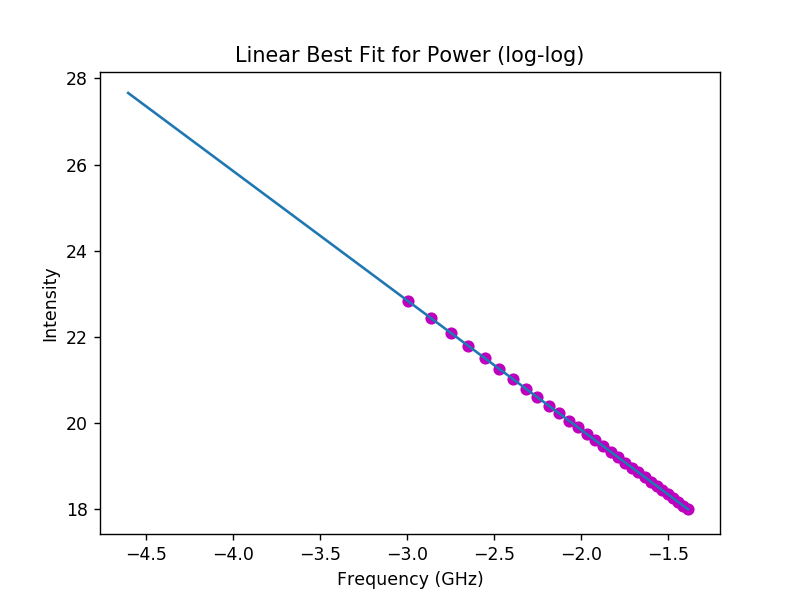

<IPython.core.display.Javascript object>


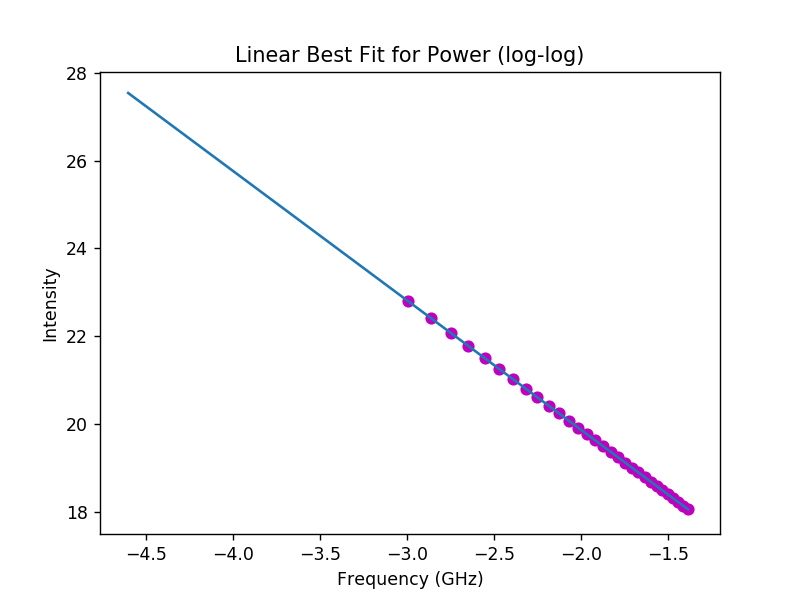

<IPython.core.display.Javascript object>


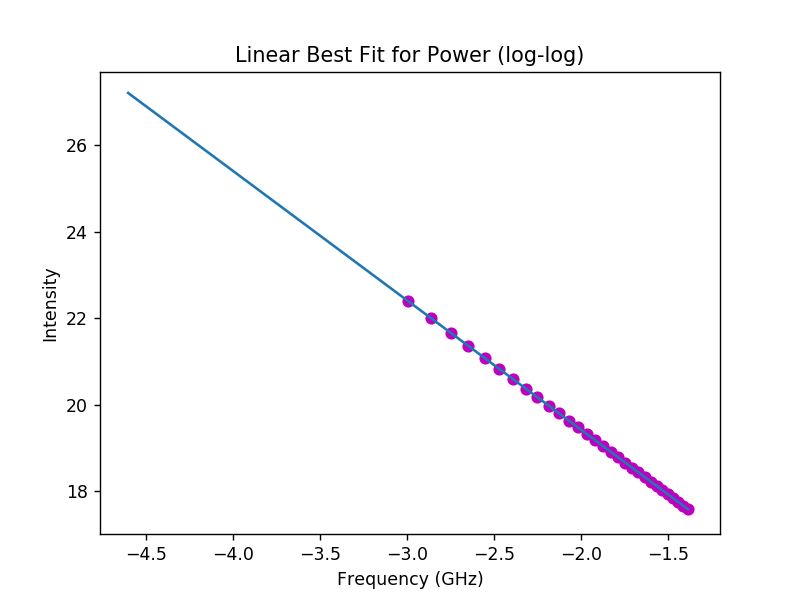

<IPython.core.display.Javascript object>


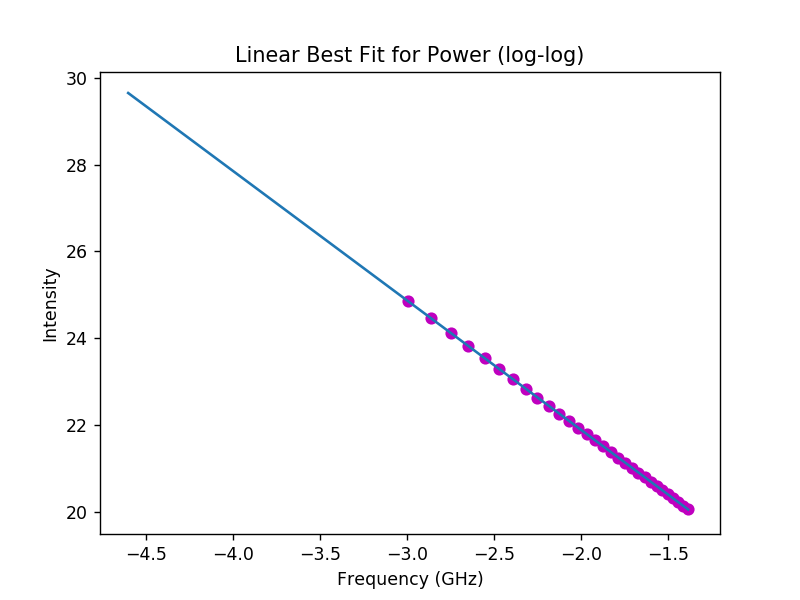

<IPython.core.display.Javascript object>


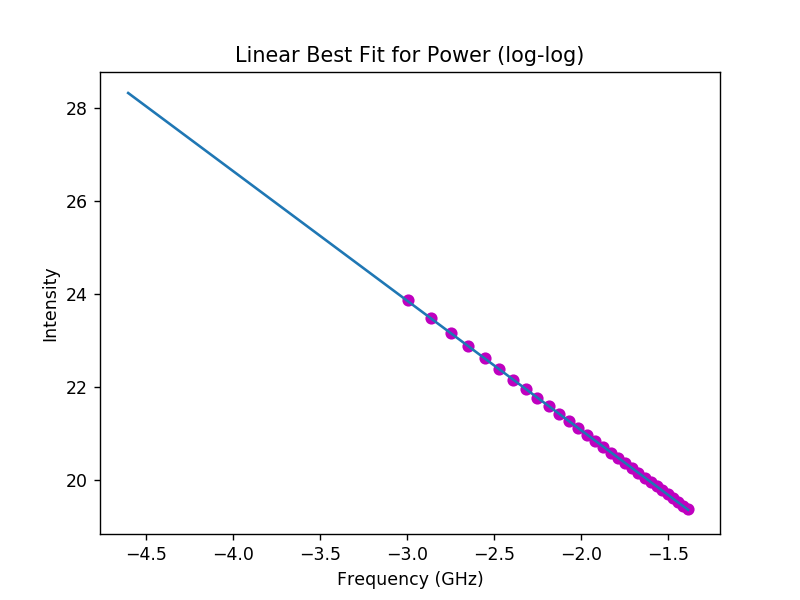

<IPython.core.display.Javascript object>


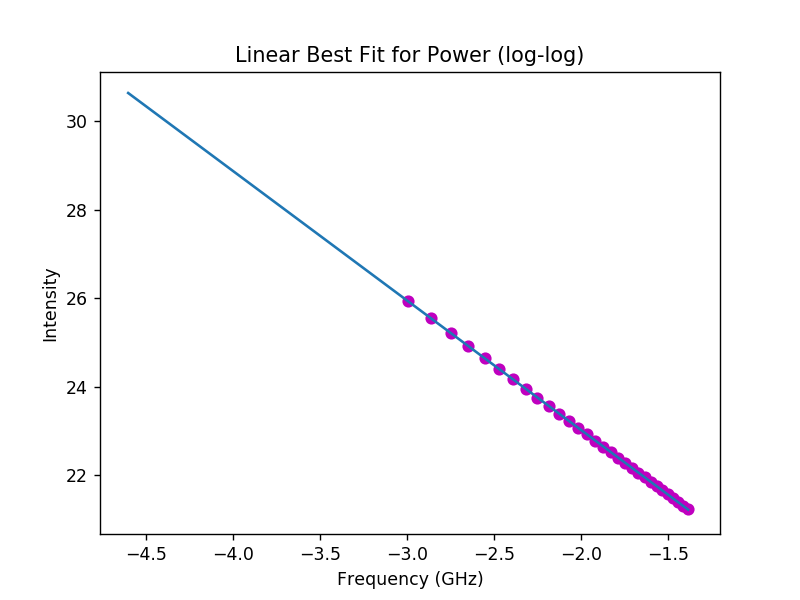

<IPython.core.display.Javascript object>


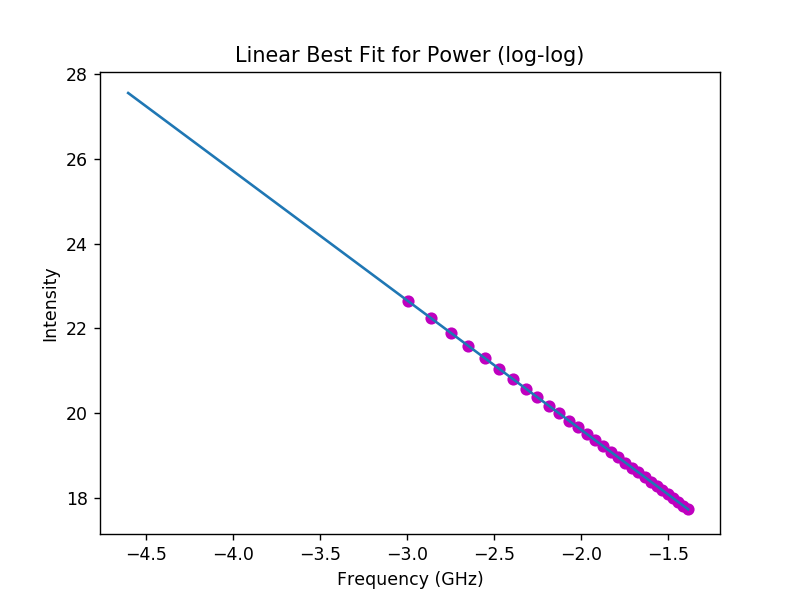

In [16]:
xval_log= np.log(arr) #finding log of x points 
for y in np.arange(9):
    plt.figure()
    yval_log =np.log(avg_data['Intensity'].iloc[y*30:30*(y+1)]) #log of y points
    pow_fit, pow_param, pow_error = y_model(xmatrix_pow, xval_log, yval_log) 
    plt.plot(xval_log, pow_fit, label='power')
    plt.scatter(np.log(xpoints),yval_log, color='m')
    plt.title("Linear Best Fit for Power (log-log)")
    plt.xlabel(xpoints.name)
    plt.ylabel(ypoints.name)
    plt.show()

# Error Covariance

This is to find error information on final parameters to ascertain how far the fit is to the true parameters. To determine it, use the error covariance defined as $V= [A^{T}N^{-1}A]^{-1}$. The square root of the diagonal of $V$ gives the error bar of each parameter. The off-diagonal elements tell us how the errors on different parameters are correlated. 

In [19]:
def error_bar(x_matrix):
    return np.sqrt(np.diag(x_matrix)) #taking the square root of the diagonal of V

# Errors for Parameters

This is the error for parameters of the linear fit. The parameters are $b$ for intercept and $m$ for slope from the equation $y=mx+b$.

In [20]:
error_cov_lin = error_bar(lin_error)
print('Error covariance for linear fit is\n', error_cov_lin)
print('\nThe slope (m) is', lin_param[1],'+/-', error_cov_lin[1], '(',lin_param[1]+error_cov_lin[1],',',
      lin_param[1]-error_cov_lin[1],')')
print('The intercept (b) is', lin_param[0],'+/-', error_cov_lin[0],'(',lin_param[0]+error_cov_lin[0],',',
      lin_param[0]-error_cov_lin[0],')')

Error covariance for linear fit is
 [2.71367413e+07 1.21261098e+08]

The slope (m) is -2071059569.3364906 +/- 121261098.19486754 ( -1949798471.141623 , -2192320667.5313582 )
The intercept (b) is 544123686.4998655 +/- 27136741.30954511 ( 571260427.8094107 , 516986945.19032043 )


This is the error for the parameter of the power law fit. The parameters are $log(\beta)$ and $\alpha$ for the equation $y^{'} = log(\beta) + \alpha x^{'}$. Note that $y^{'}=log(y)$ and $x^{'}=log(x)$ and that it's for a log-log graph.

In [ ]:
# print('Error covariance for power law fit is \n', error_cov(xmatrix_pow))
# print('\nLog(beta) is', pow_param[1],'+/-', error_bar(xmatrix_pow)[1], '(',pow_param[1]+error_bar(xmatrix_pow)[1],',',
#       pow_param[1]-error_bar(xmatrix_pow)[1],')')
# print('Alpha is', pow_param[0],'+/-', error_bar(xmatrix_pow)[0],'(',pow_param[0]+error_bar(xmatrix_pow)[0],',',
#       pow_param[0]-error_bar(xmatrix_pow)[0],')')

Calculating sigma using a different method and finding the corresponding error for the power law parameters. Here, it seems that the error has been substantially reduced. The error for log is $$\delta y^{'}= \frac{d log(y)}{dy} = \frac{\delta y}{y}$$.

In [ ]:
# sigma = (1/(np.sqrt(np.abs(yval_log)))).reshape((ypoints.size,1))
# sigma= np.hstack(sigma)
# noise_cov = np.diag(sigma)
# err_pow = error_cov(xmatrix_pow)
# print(err_pow)
# print('\nLog(beta) is', pow_param[1],'+/-', error_bar(xmatrix_pow)[1], '(',pow_param[1]+error_bar(xmatrix_pow)[1],',',
#       pow_param[1]-error_bar(xmatrix_pow)[1],')')
# print('Alpha is', pow_param[0],'+/-', error_bar(xmatrix_pow)[0],'(',pow_param[0]+error_bar(xmatrix_pow)[0],',',
#       pow_param[0]-error_bar(xmatrix_pow)[0],')')

# Goodness of Fit

### $\chi^{2}=\sum_{i=1} \frac{(y_{i}-\hat{m}_{i}-\hat{b})^{2}}{\sigma_{i}^{2}}$

In [ ]:
var = np.sum(((ypoints - avg_x)**2)/(xpoints.size))
residual_sq = (ypoints-lin_fit)**2
chi_square = np.sum(residual_sq/(var))
print(chi_square)

In [ ]:
var = np.sum(((ypoints - avg_x)**2)/(xpoints.size))
residual_sq = (ypoints-lin_fit)**2
chi_square = np.sum(residual_sq/(var))